In [13]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

In [14]:
iterations=10
channels=3
image_size=500
image_width=image_size
image_height=image_size
image_rgb=[123.68, 116.779, 103.939]
content_w=0.02
style_w=4.5
total_variation_w=0.995
total_variation_loss_factor=1.25

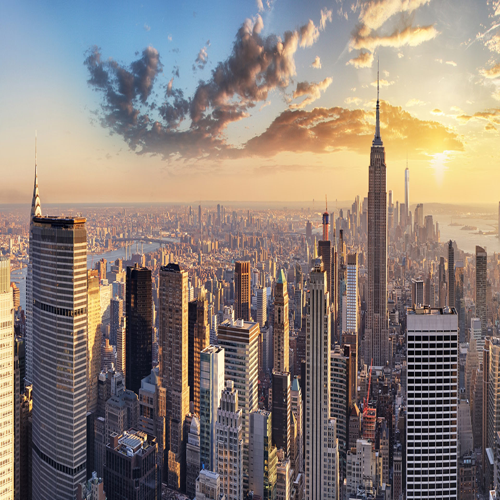

In [15]:
input_im_path="input.png"
style_im_path="style.png"
output_im_path="output.png"
merged_im_path="merged.png"
New_york="https://d12dkjq56sjcos.cloudfront.net/pub/media/wysiwyg/newyork/01-city-landing/New-York-Skyline-Big-Bus-Tours-Jan-2018.jpg"
painting="https://miro.medium.com/max/2560/1*yOmBkzDKE6HuWOvrWw1E1Q.jpeg"
input_image = Image.open(BytesIO(requests.get(New_york).content))
input_image = input_image.resize((image_width, image_height))
input_image.save(input_im_path)
input_image


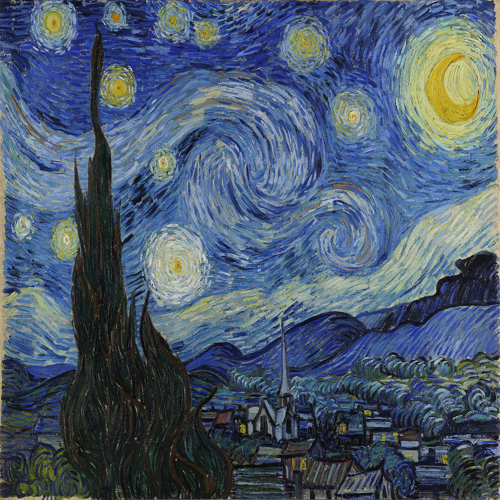

In [16]:
style_image = Image.open(BytesIO(requests.get(painting).content))
style_image = style_image.resize((image_width, image_height))
style_image.save(style_im_path)
style_image


In [17]:
input_im_array = np.asarray(input_image, dtype="float32")
input_im_array = np.expand_dims(input_im_array, axis=0)
input_im_array[:, :, :, 0] -= image_rgb[2]
input_im_array[:, :, :, 1] -= image_rgb[1]
input_im_array[:, :, :, 2] -= image_rgb[0]
input_im_array = input_im_array[:, :, :, ::-1]


In [18]:
style_im_array = np.asarray(style_image, dtype="float32")
style_im_array = np.expand_dims(style_im_array, axis=0)
style_im_array[:, :, :, 0] -= image_rgb[2]
style_im_array[:, :, :, 1] -= image_rgb[1]
style_im_array[:, :, :, 2] -= image_rgb[0]
style_im_array = style_im_array[:, :, :, ::-1]


In [19]:
input_image = backend.variable(input_im_array)
style_image = backend.variable(style_im_array)
merged_image = backend.placeholder((1, image_height,image_size, 3))


In [20]:
input_tensor = backend.concatenate([input_image,style_image,merged_image], axis=0)
model = VGG16(input_tensor=input_tensor, include_top=False)


In [21]:
def content_loss(content, merged):
    return backend.sum(backend.square(merged - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_im_features = layer_features[0, :, :, :]
merged_features = layer_features[2, :, :, :]
loss = backend.variable(0.)
loss  = loss + (content_w * content_loss(content_im_features,
                                      merged_features))



In [22]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram


In [23]:
def compute_style_loss(style, merged):
    style = gram_matrix(style)
    merged = gram_matrix(merged)
    size = image_height * image_width
    return backend.sum(backend.square(style - merged)) / (4. * (channels ** 2) * (size ** 2))
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

In [12]:
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    merged_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, merged_features)
    loss = loss + ((style_w / len(style_layers)) * style_loss)
def total_variation_loss(x):
    a = backend.square(x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :])
    b = backend.square(x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :])
    return backend.sum(backend.pow(a + b, total_variation_loss_factor))

loss= loss+ (total_variation_w * total_variation_loss_factor(merged_image))
outputs = [loss]
outputs =outputs+ backend.gradients(loss, merged_image)

TypeError: 'float' object is not callable

In [ ]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, image_height, image_width, channels))
    outs = backend.function([merged_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients



In [ ]:
class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()
x = np.random.uniform(0, 255, (1, image_height, image_width, 3)) - 128.

for i in range(iterations):
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((image_height,  image_width,channels))
x = x[:, :, ::-1]
x[:, :, 0] =x[:, :, 0] + image_rgb[2]
x[:, :, 1] =x[:, :, 1] + image_rgb[1]
x[:, :, 2] =x[:, :, 2] + image_rgb[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_im_path)
